## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [142]:
import string
import os
import torch, torch.nn as nn
import numpy as np
from random import sample
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from torch.nn import utils
from tqdm import tqdm_notebook as tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [143]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

### Data loading: "Евгений Онегин"


In [ ]:
#!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('/content/drive/MyDrive/Colab_Notebooks/onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.
# Your great code here
text = ' '.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(' '.join(text).lower()))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
# Your great code here
token_to_idx = {char : index for index, char in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {index : char for index, char in enumerate(tokens)}

In [ ]:
num_tokens = len(tokens)
num_tokens

83

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
sequence = [token_to_idx[char] for char in text]
SEQ_LEN = 250
BATCH_SIZE = 32

In [144]:
def get_batch(sequence, seq_len=SEQ_LEN, batch_size=BATCH_SIZE):
    trains = []
    tests = []
    for _ in range(batch_size):
        start = random.randint(0, len(sequence)-seq_len)
        batch_piece = sequence[start : start+seq_len]
        trains.append(torch.LongTensor(batch_piece[:-1]).view(-1,1))
        tests.append(torch.LongTensor(batch_piece[1:]).view(-1,1))
    return torch.stack(trains), torch.stack(tests)

In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=40, hidd_size=64):
        super(VanillaRNN, self).__init__()
        self.hidd_size = hidd_size
        
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, hidd_size, batch_first=True)
        self.to_logits = nn.Linear(hidd_size, num_tokens)
        
    def forward(self, x, hidden):
        h_seq, _ = self.rnn(self.emb(x).squeeze(2), hidden)
        seq_logits = self.to_logits(h_seq)
        return h_seq, seq_logits
    
    def initial_state(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidd_size, requires_grad=True)

In [166]:
def train_loop(model, crit, opt, seq, num_tok, n_epochs=1000, hidd_size = 64):
  loss_avg = []

  for i in tqdm(range(n_epochs)):
      model.train()
      opt.zero_grad()
      
      train, target = get_batch(seq)
      train, target = train.to(device), target.to(device)
      hidden = model.initial_state(batch_size=BATCH_SIZE)
      hidden, output = model(train, hidden)
      p_next = F.log_softmax(output, dim=-1)
      loss = crit(p_next.view(-1, num_tok), 
                      target.squeeze(-1).view(-1))
      
      loss.backward()
      opt.step()
      
      loss_avg.append(loss.item())

      # if (i+1)%100==0:
      #     clear_output(True)
      #     plt.plot(loss_avg,label='loss')
      #     plt.legend()
      #     plt.show()
          
  return loss_avg

In [ ]:
hidd_size = 64
vanilla = VanillaRNN(num_tokens=num_tokens, hidd_size=hidd_size, emb_size=40).to(device)

criterion_vanilla = nn.NLLLoss()
optimizer_vanilla = torch.optim.Adam(vanilla.parameters())

loss_avg_vanilla = train_loop(vanilla, criterion_vanilla, optimizer_vanilla, sequence, num_tokens n_epochs=5000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Plot the loss function (axis X: number of epochs, axis Y: loss function).

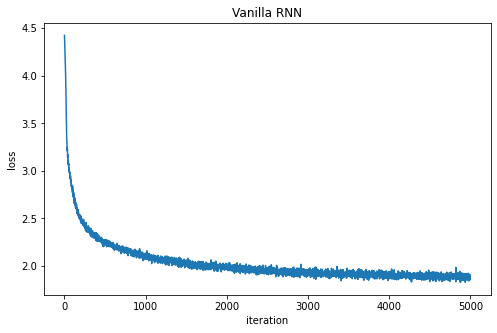

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Vanilla RNN')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(loss_avg)

In [169]:
def evaluate(model, token_to_idx, idx_to_token, num_tok, start_text=' ', prediction_len=200, temp=0.3):
    hidden = model.initial_state()
    idx_input = [token_to_idx[char] for char in start_text]
    train = torch.LongTensor(idx_input).view(1, -1, 1)
    predicted_text = start_text
    
    for i in range(len(start_text) - 1):
        hidden, _ = model(train[:,i,:], hidden)

    for i in range(prediction_len - len(start_text)):
        hidden, output = model(train[:,-1], hidden)
        output_logits = output.data.view(-1)
        p_next = F.softmax(output_logits / temp, dim=-1).data.numpy()

        top_index = np.random.choice(num_tok, p=p_next)
        predicted_char = idx_to_token[top_index]
        predicted_text += predicted_char
        
        top_index = torch.tensor([[[top_index]]], dtype=torch.int64)
        train = torch.cat([train, top_index], dim=1)
    
    return predicted_text

In [ ]:
vanilla.eval()
print(evaluate(vanilla, token_to_idx, idx_to_token, num_tokens, start_text=' ', temp=0.7, prediction_len=500))

 годо проститем стреду коневался,
 и в купому не в самом
 шуты
 мелесь празменец,
 поковою разгорой онажен не покоруз баруче
 уполне,
 что в бог отом девал.
 
 
 
 xxi
 
 гущет на своей кровил, к не больный сволей жизни в гравной кров,
 владет души не негиней девалкою розда,
 на льчтенный,
 так ль крада, как в построй всегда добременчисо, привышась дом он обноже его в ворыл она чуть в все заляне;
 и перед ней довой,
 и час он подам,
 когда, в слезумелью говорному всоскала ного своей
 и старулся 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

# Data loading "Daite tank(!)"

In [145]:
with open('/content/drive/MyDrive/Colab_Notebooks/daitetank.txt', 'r', encoding='utf-8') as iofile:
    text2 = iofile.readlines()
text2 = ' '.join(text2).lower()
tokens2 = sorted(set(' '.join(text2).lower()))
token_to_idx2 = {char : index for index, char in enumerate(tokens2)}
idx_to_token2 = {index : char for index, char in enumerate(tokens2)}
num_tokens2 = len(tokens2)
sequence2 = [token_to_idx2[char] for char in text2]
SEQ_LEN = 150
BATCH_SIZE = 32

In [146]:
num_tokens2

71

Plot the loss function of the number of epochs. Does the final loss become better?

In [167]:
class LSTMRNN(nn.Module):
    def __init__(self, num_tokens, hidd_size=64, emb_size=40):
        super(self.__class__, self).__init__()
        self.hidd_size = hidd_size
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, hidd_size, batch_first=True)
        self.to_logits = nn.Linear(hidd_size, num_tokens)
        
    def forward(self, inp, hidden):
        outp, hidden = self.rnn(self.emb(inp).squeeze(2), hidden)
        logits = self.to_logits(outp)
        #seq_logp = F.log_softmax(logits, dim=-1)
        return hidden, logits
    
    def initial_state(self, batch_size=1):
        return (torch.zeros(1, batch_size, self.hidd_size, requires_grad=True),
                torch.zeros(1, batch_size, self.hidd_size, requires_grad=True))

In [168]:
lstm = LSTMRNN(num_tokens=num_tokens2).to(device)

criterion_lstm = nn.NLLLoss()
optimizer_lstm = torch.optim.Adam(lstm.parameters())


loss_avg_lstm = train_loop(lstm, criterion_lstm, optimizer_lstm, sequence2, num_tokens2, n_epochs=5000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


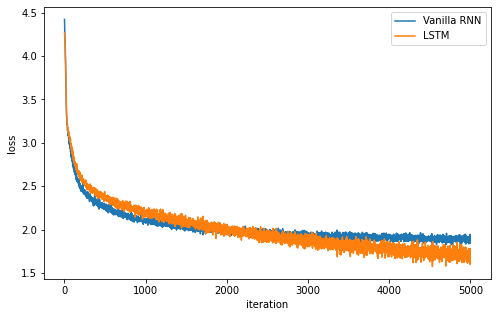

In [170]:
plt.figure(figsize=(8,5))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(loss_avg_vanilla)
plt.plot(loss_avg_lstm)
plt.legend(['Vanilla RNN', 'LSTM'])

У Vanilla RNN градиенты затухают быстрее и поэтому loss быстрее выходит на константу.

In [190]:
lstm.eval()
print(evaluate(lstm, token_to_idx2, idx_to_token2, num_tokens2, start_text=' ', temp=0.8, prediction_len=500))

 от головы.
 
 и я ну мазике последнего всё любой.
 моя, от когди свернива.
 поджилил это собидется
 положие кармой. 
 был хорогах молу. 
 «мои долгить головы, 
 в как дела, и ты вре ухок. 
 что поротом закла.
 скажу знаю 
 последнея и черет на случах обрапруди: я лек. 
 колычно сто верки дила и виду илова и сыбы. 
 обжинатся мы от стать -
 вот умелиц
 только в и зовою прожеватся, всё новол, двшей в этом со ком старел, их ускель. 
 не лиском, поторов. 
 ни блошаем и пойдля не мог. 
 я тебе повог


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [185]:
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
  print('temperature = ', temp)
  print(evaluate(lstm, token_to_idx2, idx_to_token2, num_tokens2, start_text=' ', temp=temp, prediction_len=200))
  print('----------------------------')

temperature =  0.1
 не спростица и не спрость положиться. 
 на видели на качелях. 
 я не спрость на качелях. 
 я не водоём, на водоём, на водоём, на водоём, на водоём, на водоём, на водоём, на водоём, на водоём, на водо
----------------------------
temperature =  0.2
 нас в не привый в реко.
 сторов. 
 все моловек и не спрость на качелях. 
 я не по разбитить. 
 на руками покажал сводожит и на качелях. 
 я не спрость на качелях. 
 я тебя на качелях. 
 я не спрость 
----------------------------
temperature =  0.5
 как под такаю молого нет первых перечить сторов. 
 как вопросире не виду ни просто все замёрленный фосольно волко обжал фамерные себе и не замёрт. 
 на меня в волке не спить, кто старый весели за гла
----------------------------
temperature =  1.0
 чтобы.
 
 нас угорная своя
 я не упусь.
 шектаряй,
 чюдом берег ещё. 
 а сайдениеби скуменики капала менянютькой в и зрествать он на прошен вилой.
 и едле нам холоднаями поогдъе не миры когоди мою чу
----------------------------
temp

Чем выше температура, тем выше хаотичность текста. Символы становятся почти равновероятными и поэтому получается каша. Наоборот, если температура слишком низкая, то текст может зациклиться, как видно на примере с temp=0.1.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [193]:
save_checkpoint('/content/drive/MyDrive/Colab_Notebooks/vanillaRNN.path', vanilla, optimizer_vanilla)

model saved to /content/drive/MyDrive/Colab_Notebooks/vanillaRNN.path


In [194]:
save_checkpoint('/content/drive/MyDrive/Colab_Notebooks/lstmRNN.path', lstm, optimizer_lstm)

model saved to /content/drive/MyDrive/Colab_Notebooks/lstmRNN.path


In [195]:
load_checkpoint('/content/drive/MyDrive/Colab_Notebooks/vanillaRNN.path', vanilla, optimizer_vanilla)

model loaded from /content/drive/MyDrive/Colab_Notebooks/vanillaRNN.path


In [196]:
load_checkpoint('/content/drive/MyDrive/Colab_Notebooks/lstmRNN.path', lstm, optimizer_lstm)

model loaded from /content/drive/MyDrive/Colab_Notebooks/lstmRNN.path


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)